# Calculate and plot air-sea fluxes

## Load packages and define parameters

Air-sea gas exchange toolbox downloaded from https://github.com/boom-lab/gasex-python

In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import time
import gsw
import cartopy
from cartopy import crs as ccrs, feature as cfeature
import matplotlib.pyplot as plt
from gasex import airsea
from matplotlib import ticker
import dask.array as da
import cmocean

In [6]:
lat_lim = [30, 66]
lon_lim = [-79.5, -4.5]
cnv_day = 86400; dt = 0.25;
beta = 1.5;

## Load data

### GOBAI-O2 gridded oxygen data

In [9]:
ds = xr.open_mfdataset('../data/GOBAI-O2-v2.2.nc', chunks={'time': 12})
ds_NA = ds.sel(lat=slice(lat_lim[0], lat_lim[1]), lon=slice(lon_lim[0], lon_lim[1]))
# Calculate absolute salinity, conservative temperature, and potential density
ds_NA['sa']  = gsw.SA_from_SP(ds_NA.sal, ds_NA.pres, -56.5, 52.5);
ds_NA['ct'] = gsw.CT_from_t(ds_NA.sa, ds_NA.temp, ds_NA.pres);
ds_NA['sigma'] = gsw.sigma0(ds_NA.sa, ds_NA.ct);

# Convert oxygen from umol/kg to mol/m3
ds_NA['oxy_mol_m3'] = ds_NA.oxy*(ds_NA.sigma+1000)/1e6;
# Calculate oxygen solubility and saturation percentage
ds_NA['o2s'] = gsw.O2sol(ds_NA['sa'], ds_NA['ct'], ds_NA['pres'], ds_NA['lon'], ds_NA['lat'])
ds_NA['sat'] = ds_NA['oxy']/ds_NA['o2s']*100

lon2, lat2 = np.meshgrid(ds_NA['lon'], ds_NA['lat'])
# area of each grid cell
ds_NA['ar'] = xr.DataArray(1852*60*1852*60.*np.cos(lat2/180*np.pi), coords={'lat': ds_NA['lat'], 'lon': ds_NA['lon']}, 
                          dims=['lat', 'lon'])


### ERA5 atmospheric forcing data

In [11]:
file_era = '../../MATLAB/data/era5/ERA5_SPNA-6H.nc';
file_era_rh = '../../MATLAB/data/era5/ERA5_SPNA_2004_2023_rh.nc';
ds_ERA1 = xr.open_mfdataset([file_era], chunks={'time': 365}).sel(expver=1)
ds_ERA2 = xr.open_mfdataset([file_era_rh], chunks={'valid_time': 365}).rename({'valid_time':'time'})

# Combine
ds_ERA = xr.merge([ds_ERA1, ds_ERA2.sel(pressure_level=1e3, method='nearest').drop_vars(['number', 'expver'])])
ds_ERA = ds_ERA.rename({'longitude':'lon', 'latitude':'lat'})

# Extract data at GOBAI-O2 grid points
ds_ERA_NA = ds_ERA.sel(lat=ds_NA['lat'], lon=ds_NA['lon'])

# Define absolute velocity and drop u and v components
ds_ERA_NA['vel'] = np.sqrt(ds_ERA_NA['u10']**2+ds_ERA_NA['v10']**2)
ds_ERA_NA = ds_ERA_NA.drop_vars(['u10', 'v10'])

### Combined dataset
Extract GOBAI data at surface (`pres = 2.5`) and interpolate to ERA timestep; combine GOBAI and ERA data

In [13]:
ds_NA_flx = xr.merge([ds_NA.sel(pres=2.5).interp_like(ds_ERA_NA), ds_ERA_NA])
ds_NA_flx_ch = ds_NA_flx.chunk({'time': 365})

## Data analysis

### Calculate oxygen inventory
Define pressure bounds from central pressures, then convert to depth space. Calculate oxygen inventory by multiplying `oxy_mol_m3` and `dz`, then summing in depth

In [16]:
p_bounds = np.zeros((58, 2))
p_bounds[0, 0] = 0; p_bounds[0, 1] = 5;
for pp in range(1, ds_NA['pres'].shape[0]):
    p_bounds[pp, 0] = p_bounds[pp-1, 1];
    dp = ds_NA['pres'][pp]-p_bounds[pp, 0];
    p_bounds[pp, 1] =  ds_NA['pres'][pp]+dp;

pbn = np.tile(np.expand_dims(p_bounds, axis=(2, 3)),(1,1,lat2.shape[0],lat2.shape[1]))
z_bounds = -gsw.z_from_p(pbn, lat2)
dz = np.squeeze(np.diff(z_bounds, axis=1))
o2inv = (ds_NA['oxy_mol_m3']*dz).sum(dim='pres')

### Calculate air-sea fluxes
Using Liang 2013 parameterization with bubble parameters multiplied by $\beta = 1.5$; see paper for details

In [18]:
# Define wrapper function to allow chunked xarray input
def L13_wrapper(oxy, vel, sal, temp, slp,rh, gas=None):
    return (airsea.L13(oxy, vel, sal, temp, slp=slp, rh=rh, gas=gas))

(Fd, Fc, Fp, _, _) = xr.apply_ufunc(L13_wrapper, ds_NA_flx_ch['oxy_mol_m3'], ds_NA_flx_ch['vel'], 
                              ds_NA_flx_ch['sal'], ds_NA_flx_ch['temp'], 
                              ds_NA_flx_ch['msl']/101325, ds_NA_flx_ch['r']/100,
                              dask='parallelized', kwargs={'gas': 'O2'},
                              output_dtypes=np.tile(ds_NA_flx_ch['oxy'].dtype, [5, ]),
                              output_core_dims=[[], [], [], [], []])

# Calculate total flux from different components, scaled by sea ice concentration
ds_NA_flx_ch['flx_l13'] = (Fd + beta*Fc + beta*Fp)*(1-ds_NA_flx_ch['siconc']);
ds_NA_flx_ch['flx_l13'].assign_attrs(units='mol m^{-2} s^{-1}', description='Air-sea flux of oxygen');

### Convert back to monthly data
Use `resample` to sum data by month, then add back to `ds_NA` dataset. Extract data for subpolar North Atlantic only as `ds_SPNA`

In [20]:
flxm = (ds_NA_flx_ch['flx_l13']*cnv_day*dt).resample({'time': 'M'}).sum()
ds_NA['flx_month'] = flxm.reindex_like(ds_NA, method = 'bfill')

# Multiply by cell area to convert from mol/m2 to mol
ds_NA['flxar'] = ds_NA['flx_month']*ds_NA['ar']

ds_SPNA = ds_NA.sel(lat=slice(45, 65), lon=slice(-62.5, -5))
ds_SPNA.load()

/Users/jannes/anaconda3/lib/python3.11/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


<xarray.Dataset>
Dimensions:         (time: 240, pres: 58, lat: 20, lon: 58)
Coordinates:
  * lon             (lon) float32 -62.5 -61.5 -60.5 -59.5 ... -7.5 -6.5 -5.5
  * lat             (lat) float32 45.5 46.5 47.5 48.5 ... 61.5 62.5 63.5 64.5
  * pres            (pres) float32 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
  * time            (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2023-12-15
    expver          int32 1
    pressure_level  float64 1e+03
Data variables: (12/13)
    oxy             (time, pres, lat, lon) float32 nan nan nan ... nan nan nan
    temp            (time, pres, lat, lon) float32 nan nan nan ... nan nan nan
    sal             (time, pres, lat, lon) float32 nan nan nan ... nan nan nan
    uncer           (time, pres, lat, lon) float32 nan nan nan ... nan nan nan
    sa              (time, pres, lat, lon) float64 nan nan nan ... nan nan nan
    ct              (time, pres, lat, lon) float64 nan nan nan ... nan nan nan
    ...              ...
    oxy_mol_m3      (time, pres, lat, lon) float64 nan nan nan ... nan nan nan
    o2s             (time, pres, lat, lon) float64 nan nan nan ... nan nan nan
    sat             (time, pres, lat, lon) float64 nan nan nan ... nan nan nan
    ar              (lat, lon) float32 8.655e+09 8.655e+09 ... 5.316e+09
    flx_month       (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    flxar           (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

### Calculate climatological annual cycle of air-sea flux integrated in density space
For each time step, group air-sea fluxes by surface density, then sum over the bins and convert to Tmol (=1e12 mol)

In [22]:
# Define function that applies groupby operation
def gb_ufunc(data, group_var, group_bins):
    da_data = xr.DataArray(data)
    da_group = xr.DataArray(group_var)
    return da_data.groupby_bins(da_group, bins=group_bins).sum()

sig_grd = np.arange(24, 28, .05)

# Call gb_ufunc to integrate air-sea flux into bins based on surface density for each time step
flx_sig = xr.apply_ufunc(
    gb_ufunc, ds_SPNA['flxar'], ds_SPNA['sigma'].isel(pres=0), sig_grd,
    input_core_dims=[['lat', 'lon'], ['lat', 'lon'], ['sig0']],
    output_core_dims=[['sig0_bins']], 
    vectorize=True,
    output_dtypes=[ds_SPNA['flxar'].dtype],
)/1e12 # Convert from mol to Tmol

# Define sig0_bin coordinate at the bin centers
flx_sig['sig0_bins'] = (sig_grd[1:] + sig_grd[:-1])/2

## Create plots

### Overview plots
First three panels show mean oxygen inventory, surface saturation in March, and wintertime `u10` windspeed, equivalent to Fig. 2a-c in the paper. Last panel shows mean air-sea oxygen flux (Fig. 3a)

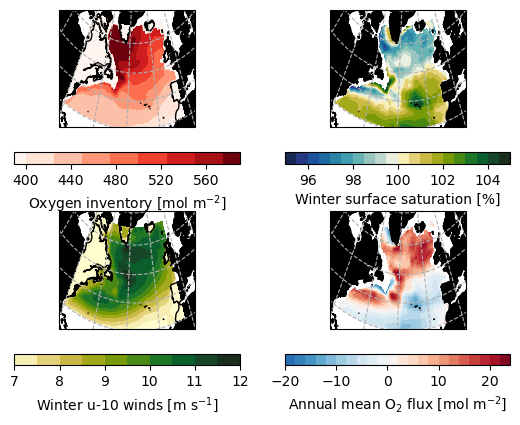

In [25]:
proj = ccrs.LambertConformal(
    central_longitude=-35.0, central_latitude=47.5)
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, 
                       subplot_kw={'projection': proj, "aspect": 1.5},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.2})

# Mean oxygen inventory
ct1 = ax[0, 0].contourf(lon2, lat2, o2inv.mean(dim='time'), vmin=390, vmax=590, 
                        levels=25, cmap='Reds', transform=ccrs.PlateCarree())
cb1 = plt.colorbar(ct1, location='bottom', ticks=ticker.MaxNLocator(nbins=5), label='Oxygen inventory [mol m$^{-2}$]')
cb1.ax.set_xlim([390, 590])

# Mean surface saturation for January - April
ct2 = ax[0, 1].contourf(
    lon2, lat2, ds_NA['sat'].sel(time=ds_NA['time'].dt.month.isin([1, 2, 3, 4]), pres=2.5).mean(dim='time'), 
    vmin=95, vmax=105, levels=21, cmap=cmocean.cm.delta, transform=ccrs.PlateCarree())
cb2 = plt.colorbar(ct2, location='bottom', ticks=ticker.MaxNLocator(nbins=6), label='Winter surface saturation [%]')
cb2.ax.set_xlim([95, 105])

# Mean u-10 windspeed for January - April
ct3 = ax[1, 0].contourf(
    lon2, lat2, ds_ERA_NA['vel'].sel(time=ds_ERA_NA['time'].dt.month.isin([1, 2, 3, 4])).mean(dim='time'), 
    vmin=7, vmax=12, levels=25, cmap=cmocean.cm.speed, transform=ccrs.PlateCarree())
cb3 = plt.colorbar(ct3, location='bottom', ticks=ticker.MaxNLocator(nbins=5), label='Winter u-10 winds [m s$^{-1}$]')
cb3.ax.set_xlim([7, 12])

# Mean annual air-sea O2 flux
ct4 = ax[1, 1].contourf(lon2, lat2, ds_NA_flx_ch['flx_l13'].mean(dim='time')*365.25*cnv_day, vmin=-25, vmax=25, levels=26, 
                        cmap='RdBu_r', transform=ccrs.PlateCarree())
cb4 = plt.colorbar(ct4, location='bottom', ticks=ticker.MaxNLocator(nbins=5), label='Annual mean O$_2$ flux [mol m$^{-2}$]')
#cb4.ax.set_xlim([-25, 25])

for ii in range(2):
    for jj in range(2):
        ax[ii, jj].set_xlabel('Longitude')
        ax[ii, jj].set_ylabel('Latitude')
        ax[ii, jj].set_extent([-80, 0, 25, 65])
        gl = ax[ii, jj].gridlines(draw_labels=False, linestyle='--', x_inline=False) 
        ax[ii, jj].add_feature(cfeature.LAND, color='k')
        ax[ii, jj].coastlines(color='k'); 

### Plot seasonal cycle and total annual uptake as a function of density
Calculate annual cycles as `flx_sig.groupby('time.month').mean()` and plot; equivalent to Fig. 6 in the paper

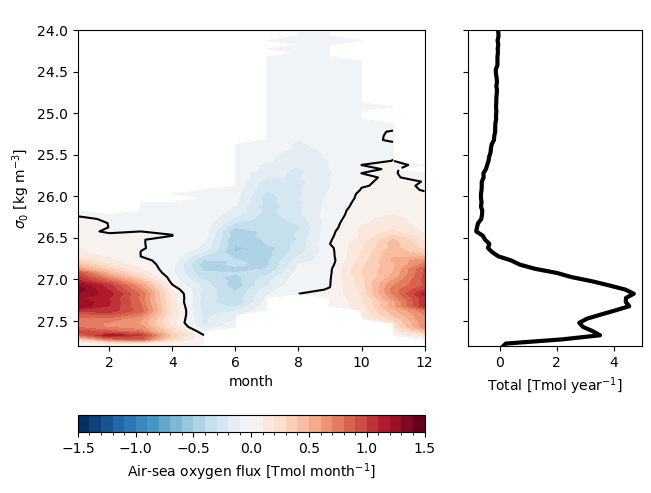

In [27]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True, layout='constrained')
flx_sig.groupby('time.month').mean().plot.contourf(ax=ax[0], levels=31, vmin=-1.5, vmax=1.5, cmap='RdBu_r', x='month',
    cbar_kwargs={"location": "bottom", 'ticks': np.arange(-1.5, 1.6, .5), 'label': 'Air-sea oxygen flux [Tmol month$^{-1}$]'})
flx_sig.groupby('time.month').mean().plot.contour(ax=ax[0], levels=[0], x='month', colors='k')
flx_sig.groupby('time.month').mean().sum(dim='month').plot(ax=ax[1], y='sig0_bins', color='k', linewidth= 3)
ax[0].set_ylim([27.8, 24])
ax[0].set_ylabel('$\sigma_0$ [kg m$^{-3}$]'); ax[0].set_title(' ')
ax[1].set_ylabel(' '); ax[1].set_title(' '); 
ax[1].set_xlabel('Total [Tmol year$^{-1}$]');